## Preprocessing – Heart Disease Dataset

Ce notebook est dédié à la phase de preprocessing du jeu de données *Heart Disease*.
Il comprend le nettoyage des données, la gestion des valeurs manquantes, l’encodage
des variables catégorielles, la mise à l’échelle des variables numériques ainsi que
la mise en place d’un pipeline reproductible en vue de la modélisation.


## Importation des bibliothèques


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


## Chargement de dataset 

In [22]:
df = pd.read_csv("dataset.csv")

In [23]:
# Print the first 10 rows of the dataset 
df.head(10)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
5,6,56,Male,Cleveland,atypical angina,120.0,236.0,False,normal,178.0,False,0.8,upsloping,0.0,normal,0
6,7,62,Female,Cleveland,asymptomatic,140.0,268.0,False,lv hypertrophy,160.0,False,3.6,downsloping,2.0,normal,3
7,8,57,Female,Cleveland,asymptomatic,120.0,354.0,False,normal,163.0,True,0.6,upsloping,0.0,normal,0
8,9,63,Male,Cleveland,asymptomatic,130.0,254.0,False,lv hypertrophy,147.0,False,1.4,flat,1.0,reversable defect,2
9,10,53,Male,Cleveland,asymptomatic,140.0,203.0,True,lv hypertrophy,155.0,True,3.1,downsloping,0.0,reversable defect,1


## Dimensions du dataset

In [24]:
# Checking the number of rows and columns
df.shape

(920, 16)

## Informations générales

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


## Aperçu général des données

Le jeu de données contient des variables numériques et catégorielles décrivant
l’état de santé de patients. Certaines variables présentent des valeurs manquantes,
ce qui nécessite une étape de nettoyage avant la modélisation.


## Analyse de valeurs manquantes

In [26]:
df.isnull().mean().sort_values(ascending=False) * 100

ca          66.413043
thal        52.826087
slope       33.586957
fbs          9.782609
oldpeak      6.739130
trestbps     6.413043
thalch       5.978261
exang        5.978261
chol         3.260870
restecg      0.217391
id           0.000000
age          0.000000
sex          0.000000
dataset      0.000000
cp           0.000000
num          0.000000
dtype: float64

## Valeurs manquantes

Plusieurs variables contiennent des valeurs manquantes en proportions variables.
Afin de conserver un maximum d’informations, une stratégie d’imputation sera utilisée
plutôt que la suppression des lignes concernées.


## Suppression des variables non pertinentes

La colonne `id` correspond à un identifiant technique et n’apporte aucune information
utile pour la prédiction. Elle est donc supprimée avant la phase de modélisation.


In [27]:
df = df.drop(columns=["id"])

## Séparation des variables explicatives et de la cible

Les données sont séparées en :
- `X` : les variables explicatives
- `y` : la variable cible (`num`)


In [28]:
X = df.drop(columns=["num"])
y = df["num"]

X.shape, y.shape

((920, 14), (920,))

## Mise en place du pipeline de preprocessing

Un pipeline est mis en place afin de gérer :
- l’imputation des valeurs manquantes
- l’encodage des variables catégorielles
- la standardisation des variables numériques

Cette approche permet d’éviter toute fuite de données et d’assurer la reproductibilité.


In [29]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

num_features, cat_features

(Index(['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca'], dtype='object'),
 Index(['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'], dtype='object'))

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [31]:
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])


In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_features),
        ("cat", categorical_pipeline, cat_features)
    ]
)


## Séparation du jeu de données

Les données sont divisées en un jeu d’entraînement et un jeu de test.
La stratification est utilisée afin de conserver la distribution de la variable cible.


In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((736, 14), (184, 14))

In [34]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed.shape, X_test_processed.shape


((736, 29), (184, 29))

## Analyse Exploratoire des Données (EDA)
Objectif : comprendre la distribution des variables, détecter l’asymétrie et les outliers, analyser les relations entre variables et étudier le lien avec la variable cible afin d’orienter la modélisation.

### Analyse univariée


In [35]:
# Variables numériques – statistiques descriptives
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

X_train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,736.0,53.315217,9.427913,28.0,47.0,54.0,60.0,77.0
trestbps,690.0,131.815942,19.272382,0.0,120.0,130.0,140.0,200.0
chol,709.0,196.232722,111.608316,0.0,170.0,223.0,267.0,603.0
thalch,694.0,137.731988,25.971184,60.0,120.0,140.0,157.0,202.0
oldpeak,687.0,0.873071,1.089769,-2.6,0.0,0.5,1.5,6.2
ca,257.0,0.653696,0.931604,0.0,0.0,0.0,1.0,3.0


c:\Users\eniol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


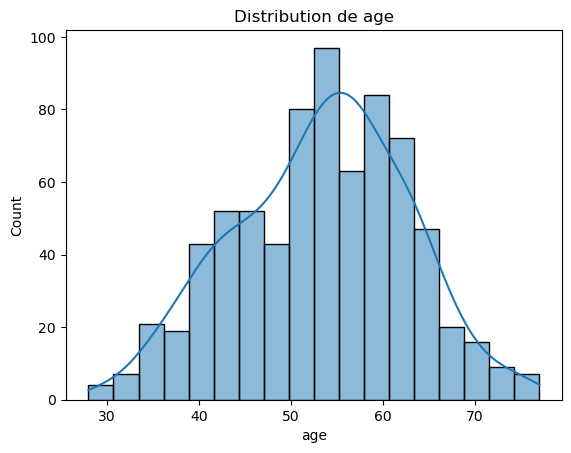

c:\Users\eniol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


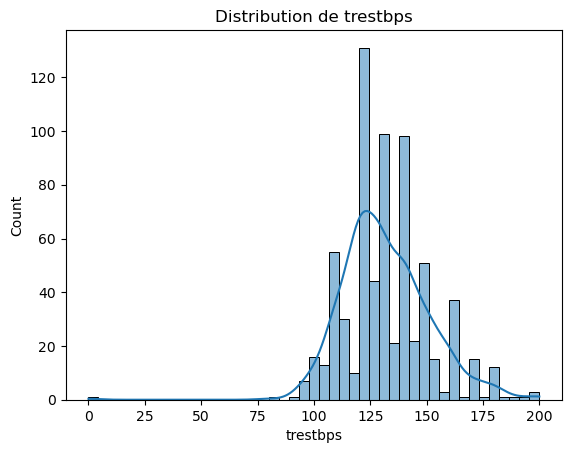

c:\Users\eniol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


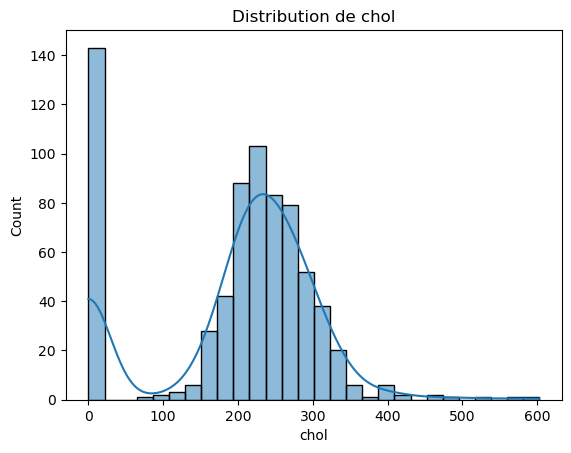

c:\Users\eniol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


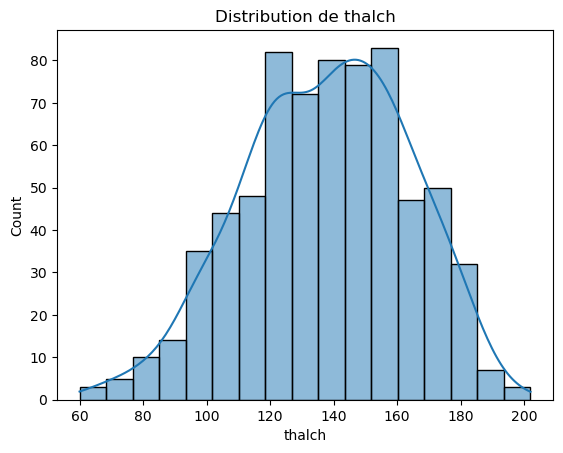

c:\Users\eniol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


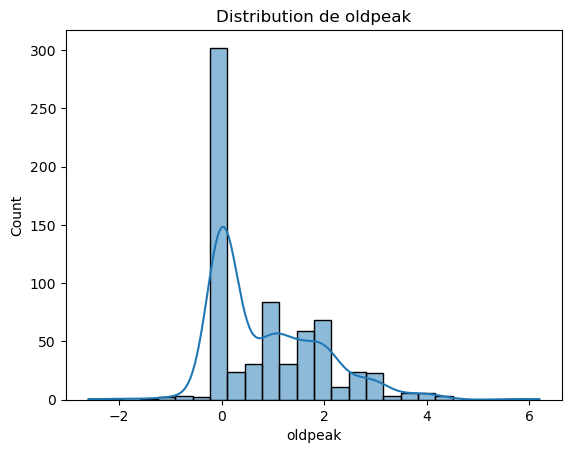

c:\Users\eniol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


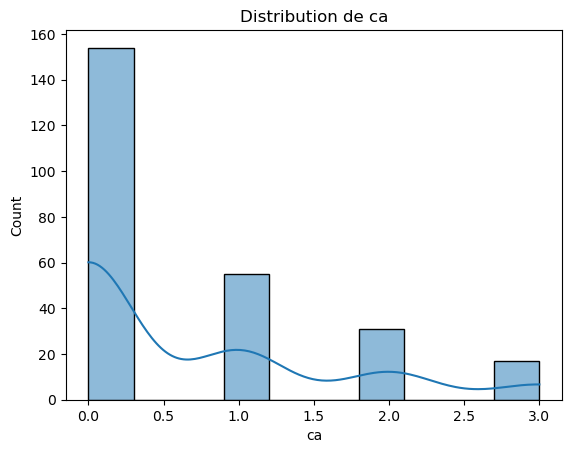

In [39]:
# Distributions
for col in num_cols:
    plt.figure()
    sns.histplot(X_train[col], kde=True)
    plt.title(f"Distribution de {col}")
    plt.show()


In [40]:
# Asymétrie (Skewness)
skewness = X_train[num_cols].skew().sort_values(ascending=False)
skewness


ca          1.239202
oldpeak     1.027317
trestbps    0.129372
age        -0.145003
thalch     -0.233312
chol       -0.589506
dtype: float64

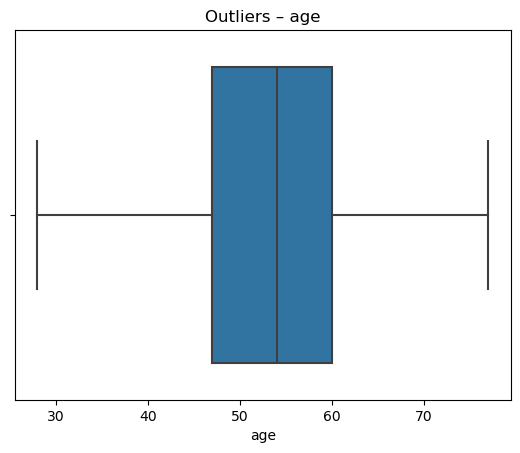

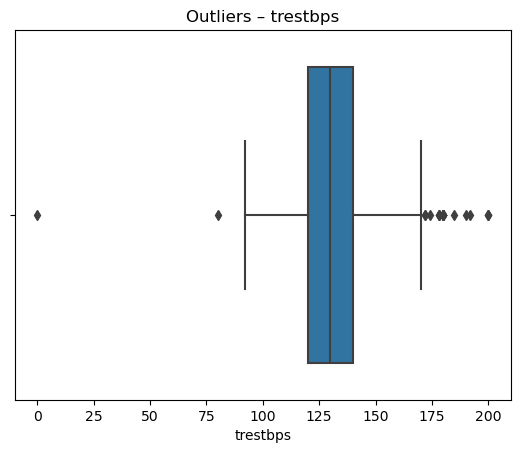

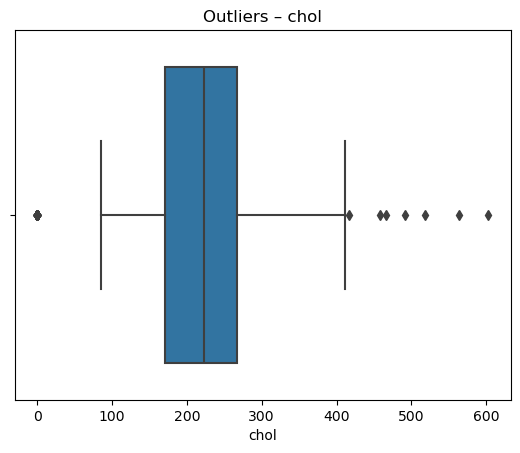

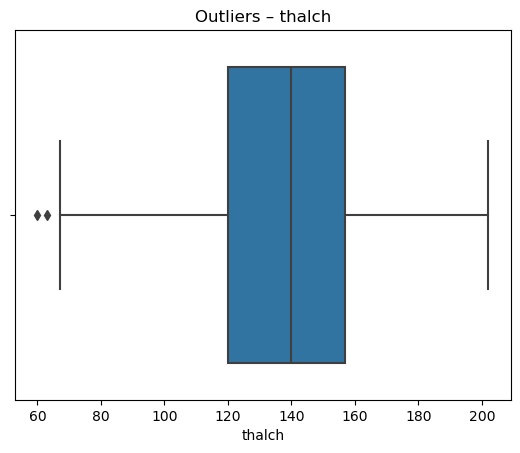

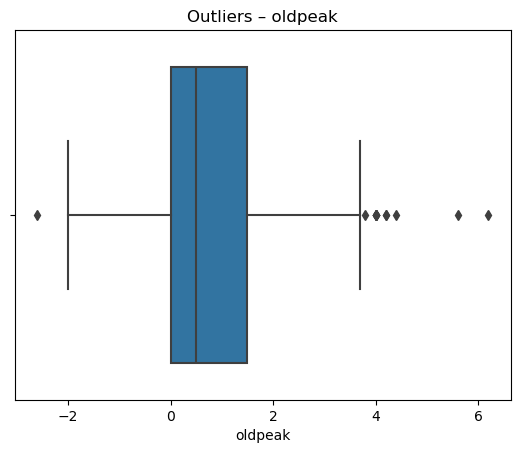

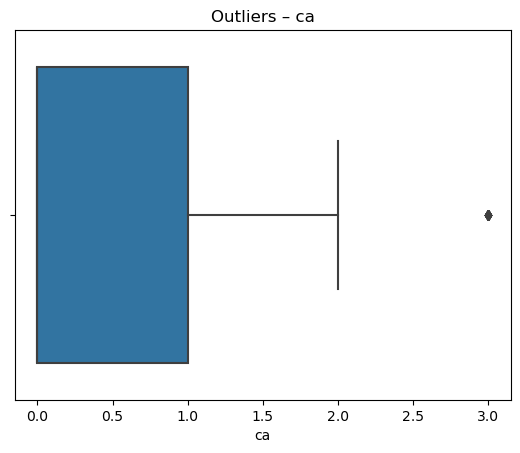

In [41]:
# Détection des outliers (Boxplots)
for col in num_cols:
    plt.figure()
    sns.boxplot(x=X_train[col])
    plt.title(f"Outliers – {col}")
    plt.show()


### Analyse bivariée / multivariée


c:\Users\eniol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\eniol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\eniol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\eniol\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

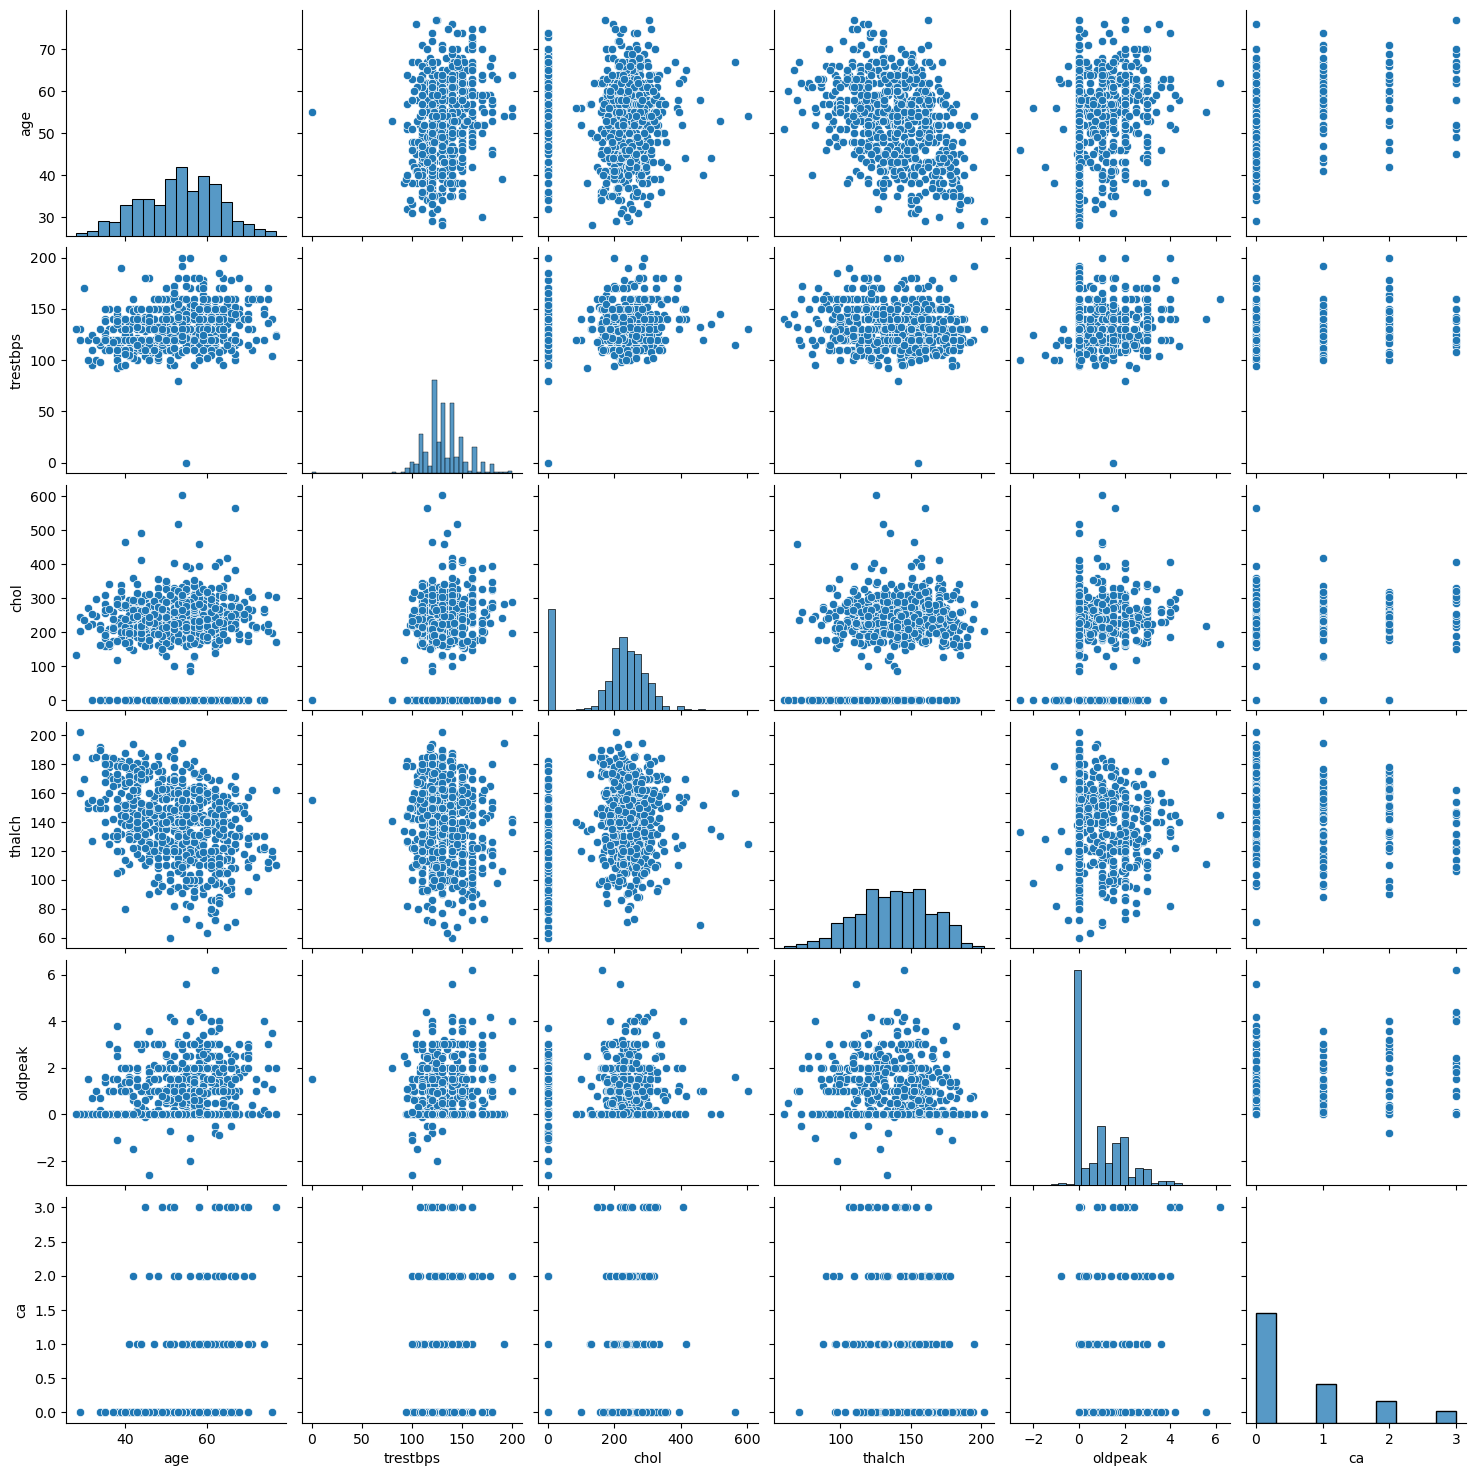

In [42]:
# Relations entre variables numériques
sns.pairplot(X_train[num_cols])
plt.show()

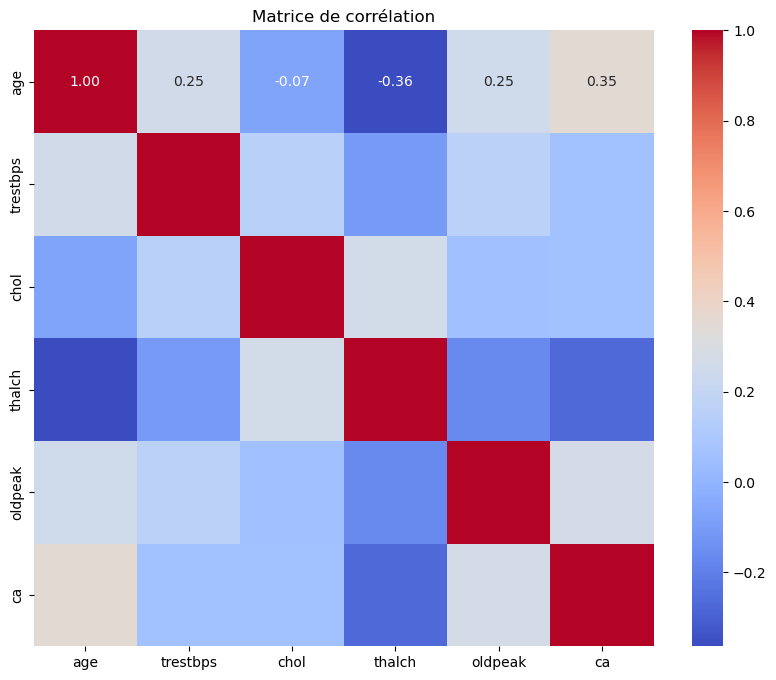

In [43]:
# Corrélations (numériques)
plt.figure(figsize=(10,8))
sns.heatmap(
    X_train[num_cols].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Matrice de corrélation")
plt.show()


### Analyse de la cible (Target)

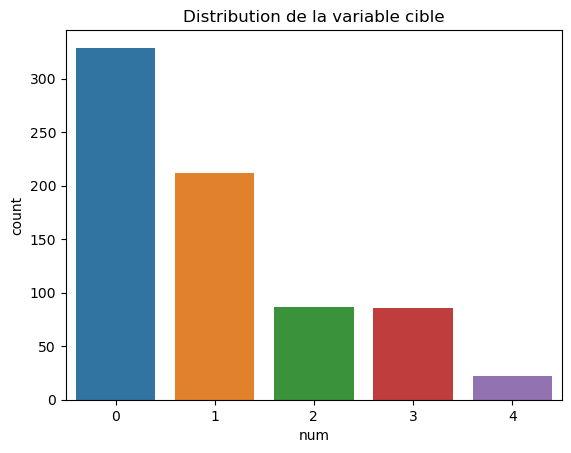

In [44]:
# Distribution de la cible
sns.countplot(x=y_train)
plt.title("Distribution de la variable cible")
plt.show()

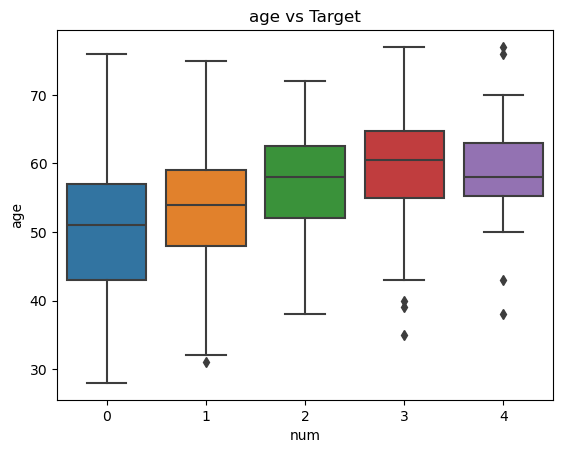

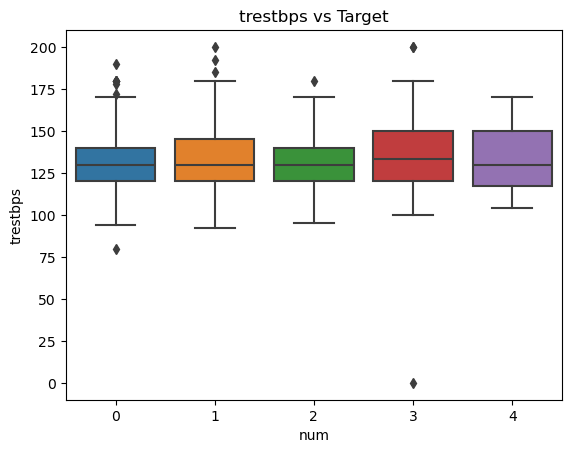

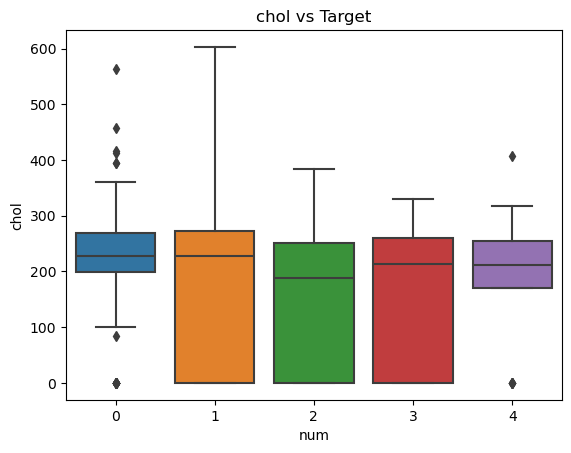

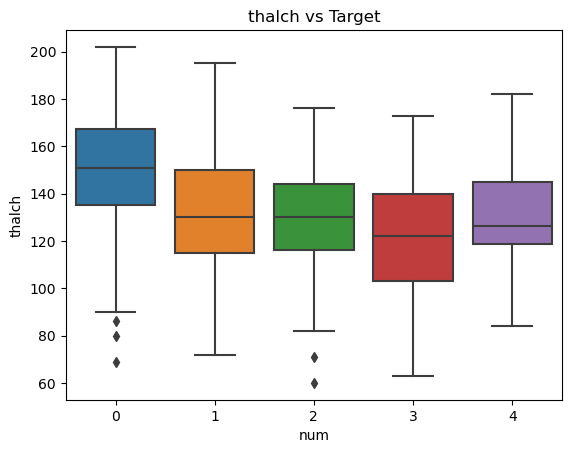

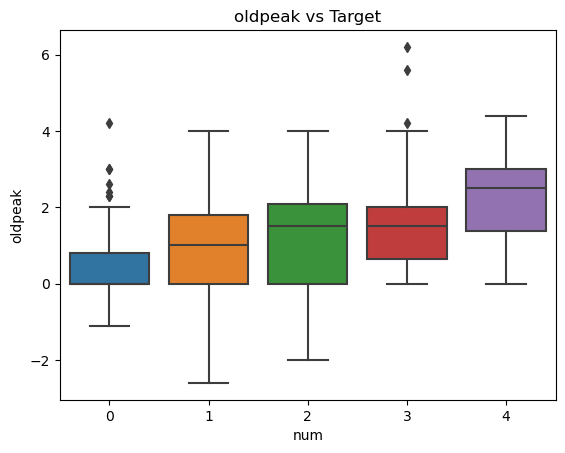

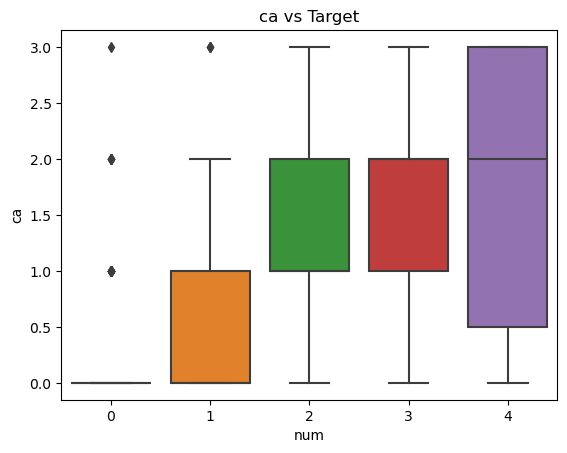

In [45]:
# Variables numériques vs cible
for col in num_cols:
    plt.figure()
    sns.boxplot(x=y_train, y=X_train[col])
    plt.title(f"{col} vs Target")
    plt.show()


In [47]:
# Variables catégorielles vs cible


## Sauvegarde du pipeline de preprocessing

Le pipeline de preprocessing est sauvegardé afin de pouvoir être réutilisé
dans la phase de modélisation sans dépendance directe entre notebooks.
Cette approche garantit la cohérence des transformations appliquées aux données
et améliore la reproductibilité du projet.


In [ ]:
import joblib

joblib.dump(preprocessor, "models/preprocessor.joblib")


['models/preprocessor.joblib']